<a href="https://colab.research.google.com/github/Jbotey12/Trade_backtesting/blob/main/Trade_backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Backtesting de una Estrategia de Trading basada en Cruce de Medias Móviles**

## Contexto
El objetivo de este proyecto es implementar y evaluar una estrategia de trading simple utilizando datos históricos de Bitcoin (BTC/USDT). Se ha aplicado la técnica del cruce de medias móviles (Moving Average Crossover), una de las más utilizadas en análisis técnico.

La hipótesis es que:

Cuando la media móvil de corto plazo (SMA50) cruza por encima de la media de largo plazo (SMA200), se genera una señal de compra (tendencia alcista).

Cuando la SMA50 cruza por debajo de la SMA200, se genera una señal de venta (tendencia bajista).

Este enfoque busca seguir la tendencia principal del mercado y evitar operar en contra de ella.

## ¿Qué son la SMA50 y la SMA200?



*   SMA (Simple Moving Average) o Media Móvil Simple es un indicador técnico que suaviza la evolución del precio promediando los valores de cierre durante un número determinado de periodos
*   SMA50: representa el promedio del precio de las últimas 50 velas (en este caso velas de 1 hora). Es un indicador de corto/medio plazo que refleja la tendencia reciente del activo.

*   SMA200: representa el promedio del precio de las últimas 200 velas. Se utiliza como referencia de tendencia de largo plazo, siendo muy popular entre traders e inversores.



La lógica detrás del cruce es sencilla:

Si la SMA50 (corto plazo) está por encima de la SMA200 (largo plazo), significa que el precio reciente es más alto que el histórico, lo que indica fuerza alcista → se interpreta como señal de compra.

Si la SMA50 está por debajo de la SMA200, indica debilidad bajista → se interpreta como señal de venta.

Este patrón es conocido como el "Golden Cross" (cuando SMA50 cruza hacia arriba la SMA200) y la "Death Cross" (cuando cruza hacia abajo).

## Obtención de Datos
Se utilizaron datos históricos de velas de 1 hora de Bitcoin extraídos de Yahoo Finance mediante la librería yfinance. El período de análisis fue de 360 días, lo que permite evaluar el desempeño de la estrategia en un contexto reciente y con suficiente granularidad temporal.

## Metodología
1. Cálculo de indicadores

SMA50: media móvil simple de 50 periodos.

SMA200: media móvil simple de 200 periodos.

2. Generación de señales de trading

Signal = 1 (BUY) cuando SMA50 > SMA200.

Signal = -1 (SELL) cuando SMA50 < SMA200.

3. Backtesting

Capital inicial: 1000 USDT.

Estrategia de todo o nada: se invierte el 100% del capital en cada señal de compra y se liquida completamente en cada señal de venta.

Registro de operaciones (fecha, tipo, precio).

Cálculo del valor final de la cartera y del beneficio neto

In [1]:
!pip install ccxt pandas


/tmp/ipython-input-780320614.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=symbol, interval=timeframe, period=period)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-780320614.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  portfolio_value = float(cash + position * df['Close'].iloc[-1].item())


💰 Capital inicial: 1000 USDT
📈 Capital final: 1294.04 USDT
✅ Beneficio total: 294.04 USDT


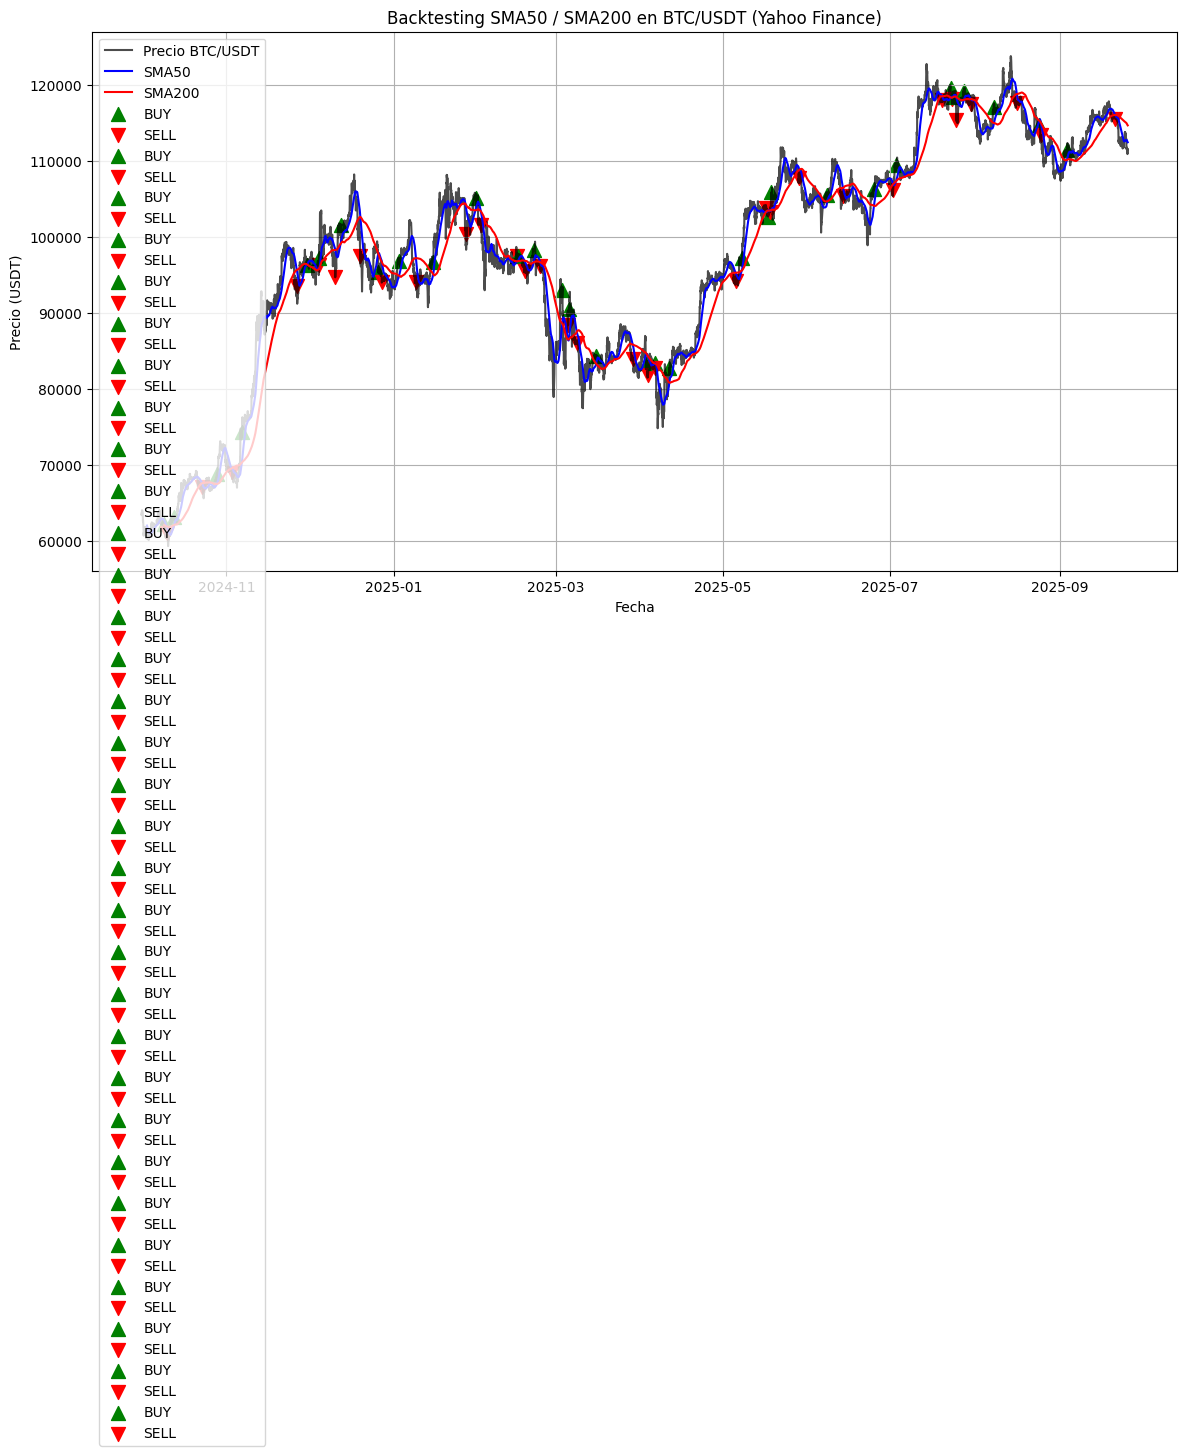

In [3]:
# Importación librerías
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Descarga datos históricos de BTC/USDT desde Yahoo
symbol = "BTC-USD"   # en Yahoo se usa BTC-USD
timeframe = "1h"     # intervalo de 1 hora
period = "360d"      # 180 días de histórico

df = yf.download(tickers=symbol, interval=timeframe, period=period)

# Calculo medias móviles
df['SMA50'] = df['Close'].rolling(window=50).mean()
df['SMA200'] = df['Close'].rolling(window=200).mean()

#  Generación señales de trading
df['Signal'] = 0
df.loc[df['SMA50'] > df['SMA200'], 'Signal'] = 1
df.loc[df['SMA50'] < df['SMA200'], 'Signal'] = -1

# Backtesting (capital inicial de 1000 USDT)
capital = 1000
position = 0
cash = capital
trades = []

for i in range(1, len(df)):
    if df['Signal'].iloc[i] == 1 and df['Signal'].iloc[i-1] != 1:  # BUY
        position = cash / df['Close'].iloc[i]
        cash = 0
        trades.append(("BUY", df.index[i], df['Close'].iloc[i]))
    elif df['Signal'].iloc[i] == -1 and df['Signal'].iloc[i-1] != -1:  # SELL
        cash = position * df['Close'].iloc[i]
        position = 0
        trades.append(("SELL", df.index[i], df['Close'].iloc[i]))

# Valor final
portfolio_value = float(cash + position * df['Close'].iloc[-1].item())
profit = portfolio_value - capital


print(f"💰 Capital inicial: {capital} USDT")
print(f"📈 Capital final: {portfolio_value:.2f} USDT")
print(f"✅ Beneficio total: {profit:.2f} USDT")

#  Graficar resultados
plt.figure(figsize=(14,7))
plt.plot(df.index, df['Close'], label='Precio BTC/USDT', color='black', alpha=0.7)
plt.plot(df.index, df['SMA50'], label='SMA50', color='blue')
plt.plot(df.index, df['SMA200'], label='SMA200', color='red')

# Marcar trades
for trade in trades:
    if trade[0] == "BUY":
        plt.scatter(trade[1], trade[2], marker="^", color="green", s=100, label="BUY")
    else:
        plt.scatter(trade[1], trade[2], marker="v", color="red", s=100, label="SELL")

plt.title("Backtesting SMA50 / SMA200 en BTC/USDT (Yahoo Finance)")
plt.xlabel("Fecha")
plt.ylabel("Precio (USDT)")
plt.legend()
plt.grid()
plt.show()

## Mejora del Backtesting: Comisiones, Slippage y Curva de Equity

Tras el primer modelo basado en el cruce SMA50/SMA200, en esta segunda versión se utiliza una estrategia más sencilla, que solo compara el precio con la SMA50 (se compra cuando el precio está por encima y se vende cuando está por debajo).

La novedad principal no está en la estrategia, sino en el realismo del backtesting:

*   Se añade una curva de equity para seguir la evolución de la cartera.
*   Se incluyen comisiones de trading (0.1%) y slippage (0.05%), factores que suelen reducir la rentabilidad en condiciones reales de mercado.


Con estas mejoras, el backtest refleja no solo el resultado final, sino también la trayectoria de ganancias y pérdidas, ofreciendo una evaluación más fiable.

/tmp/ipython-input-1193288841.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=symbol, interval="1d", period="1y")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1193288841.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(df["Close"].iloc[i])   # ✅ asegurar float escalar


💰 Capital inicial: 1000 USDT
📈 Capital final: 1115.26 USDT
✅ Beneficio total: 115.26 USDT


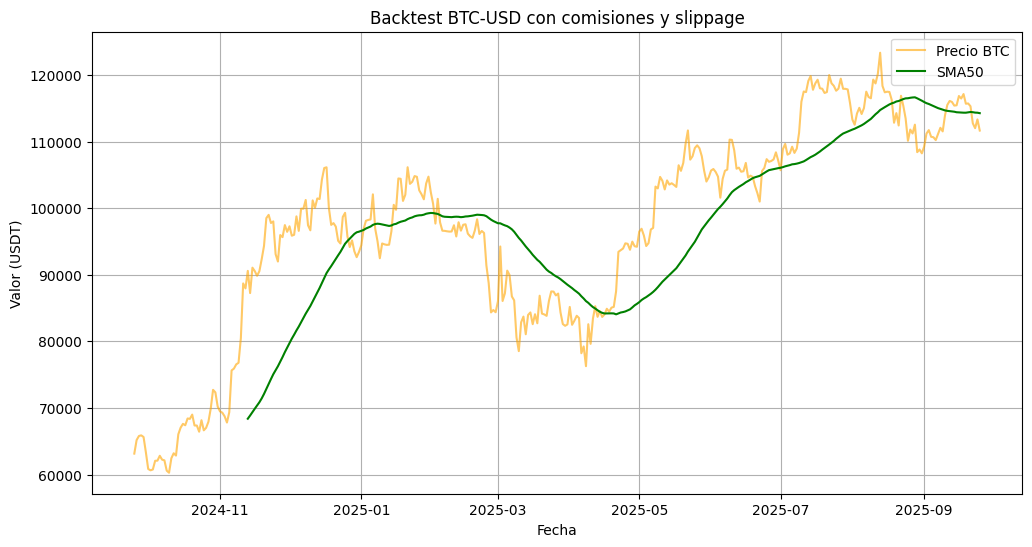

In [7]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

# Parámetros
symbol = "BTC-USD"
capital = 1000
cash = capital
position = 0
equity_curve = []

# Configuración de trading
fee_rate = 0.001    # 0.1% comisión
slippage = 0.0005   # 0.05% deslizamiento

# Descargar datos históricos
df = yf.download(tickers=symbol, interval="1d", period="1y")

# Estrategia simple con SMA50
df["SMA50"] = df["Close"].rolling(50).mean()

for i in range(len(df)):
    price = float(df["Close"].iloc[i])   # ✅ asegurar float escalar
    sma50 = df["SMA50"].iloc[i]

    # Saltar si SMA50 no existe aún
    if pd.isna(sma50):
        equity_curve.append(cash + position * price)
        continue

    # Comprar
    if price > float(sma50) and cash > 0:   # ✅ comparación escalar
        exec_price = price * (1 + slippage)
        position = (cash * (1 - fee_rate)) / exec_price
        cash = 0

    # Vender
    elif price < float(sma50) and position > 0:
        exec_price = price * (1 - slippage)
        cash = (position * exec_price) * (1 - fee_rate)
        position = 0

    # Valor actual de la cartera
    portfolio_value = cash + position * price
    equity_curve.append(portfolio_value)

# Resultados finales
final_value = equity_curve[-1]
profit = final_value - capital

print(f"💰 Capital inicial: {capital} USDT")
print(f"📈 Capital final: {final_value:.2f} USDT")
print(f"✅ Beneficio total: {profit:.2f} USDT")

# Graficar curva de equity
df["Equity"] = equity_curve
plt.figure(figsize=(12,6))
plt.plot(df.index, df["Close"], label="Precio BTC", color="orange", alpha=0.6)
plt.plot(df.index, df["SMA50"], label="SMA50", color="green")
plt.title(f"Backtest {symbol} con comisiones y slippage")
plt.xlabel("Fecha")
plt.ylabel("Valor (USDT)")
plt.legend()
plt.grid()
plt.show()

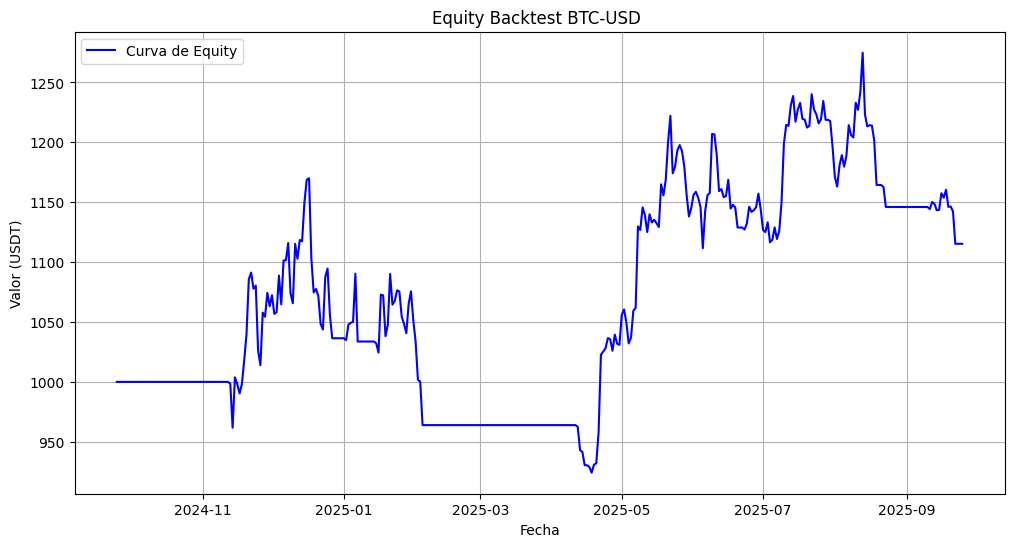

In [9]:
# Graficar curva de equity
df["Equity"] = equity_curve
plt.figure(figsize=(12,6))
plt.plot(df.index, df["Equity"], label="Curva de Equity", color="blue")
plt.title(f"Equity Backtest {symbol} ")
plt.xlabel("Fecha")
plt.ylabel("Valor (USDT)")
plt.legend()
plt.grid()
plt.show()

## Futuras mejoras del modelo



*   Optimización de parámetros: probar distintas combinaciones de medias móviles (SMA20/100, SMA10/50, EMA en lugar de SMA).
*   Gestión de riesgo: añadir reglas de stop-loss y take-profit para limitar pérdidas y asegurar beneficios.


*   Tamaño de posición dinámico: en lugar de invertir todo el capital en cada operación, aplicar gestión de riesgo basada en porcentaje del capital o volatilidad.
*   Métricas de rendimiento avanzadas: evaluar la estrategia con ratios como Sharpe Ratio, Max Drawdown o Sortino Ratio.








Estas mejoras permitirían obtener una evaluación más completa y cercana a las condiciones reales de mercado.